# Bay Wheels Exploration
## by Adrienne Terrado

## Investigation Overview

In this investigation, I want to find trends in ridership behavior over the course of the month of March. The main focus was in the number of rides taken over March and how these trends differed based on location. 

## Dataset Overview

Bay Wheels is a ride sharing company owned by Lyft. Lyft shares its system data publically on its website, albeit all trip information is kept anonymous. The dataset contains location data, the duration of each trip, whether or not the user was a subscriber, as well as many others useful for analysis. I've chosen to focus on system data for both March 2019 and 2020.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
df = pd.read_csv('202003-baywheels-tripdata.csv')
df19 = pd.read_csv('201903-fordgobike-tripdata.csv')

In [3]:
df.start_time = pd.to_datetime(df.start_time)
df.end_time = pd.to_datetime(df.end_time)
df19.start_time = pd.to_datetime(df19.start_time)
df19.end_time = pd.to_datetime(df19.end_time)

df.user_type = df.user_type.astype('category')

# Add time columns
df['week'] = df.start_time.dt.week
df['start_hour'] = df.start_time.dt.hour
df['day'] = df.start_time.dt.day
df['dow'] = df.start_time.dt.dayofweek

df19['week'] = df19.start_time.dt.week
df19['start_hour'] = df19.start_time.dt.hour
df19['day'] = df19.start_time.dt.day
df19['dow'] = df19.start_time.dt.dayofweek


df.duration_sec = df.duration_sec / 60
df.rename({'duration_sec': 'duration_min'}, axis=1, inplace = True)
df19.duration_sec = df19.duration_sec / 60
df19.rename({'duration_sec': 'duration_min'}, axis=1, inplace = True)
df['duration_hour'] = df.duration_min / 60

## A Drop in Lyfts

> San Francisco did an incredible job of enforcing stay at home orders relatively early in the course of the Covid crisis. The figure below shows changes in ridership over March this year as compared to that of March 2019. In the first week, more rides are taken in 2020 versus 2019 presumably due to company growth and/or as a result of Lyft's acquisition of Ford GoBike. Ride numbers quickly decrease soon thereafter. 

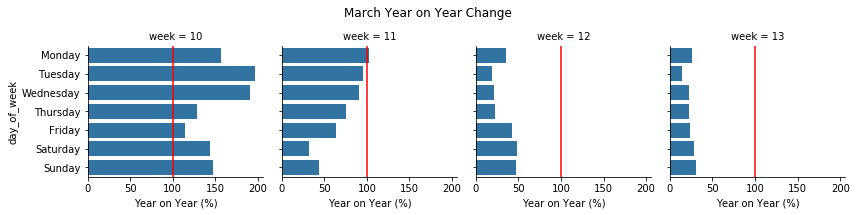

In [4]:
totalRides19 = df19[['duration_min']].groupby(by=[df19.start_time.dt.week, df19.start_time.dt.dayofweek]).count()
totalRides19.columns = ['num_rides19']

# Remove any April data from the 2020 DataFrame
df = df[df.start_time.dt.month == 3]

# Create counts DataFrame for 2020 by week of the year and day of the week
totalRides20 = df[['duration_min']].groupby(by=[df.start_time.dt.week, df.start_time.dt.dayofweek]).count()
totalRides20.columns = ['num_rides20']
totalRides20.head(1)

ride_cts_dow = totalRides20.join(totalRides19)
ride_cts_dow.index.names = ['week', 'day_of_week']

# Replace numbers with the actual days of the week, where 0 maps to "Monday" and 6 to "Sunday"
daysdict = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
ride_cts_dow = ride_cts_dow.reset_index()
ride_cts_dow.day_of_week = ride_cts_dow.day_of_week.replace(daysdict)
ride_cts_dow.dropna(how='any', inplace = True)

# Change the number of rides in 2019 to integers 
ride_cts_dow.num_rides19 = ride_cts_dow.num_rides19.astype(int)

# Remove data from week 9 
ride_cts_dow = ride_cts_dow[ride_cts_dow.week != 9]

# Create year on year column
ride_cts_dow['yoy'] = (ride_cts_dow['num_rides20'] / ride_cts_dow['num_rides19'])*100

g = sn.FacetGrid(data = ride_cts_dow, col = 'week', height = 3, sharex=True, sharey=True)
g = (g.map(sn.barplot, 'yoy', "day_of_week"))
for ax in g.axes[0]:
    ax.axvline(x=100, color= 'r')
g.set_xlabels('Year on Year (%)')
g.fig.suptitle('March Year on Year Change')
g.fig.subplots_adjust(top=0.8)
plt.show(g)

## Ridership Behavior over the Day

Lyft users tend to use Lyft bikes before the beginning of a typical work day and just as work tends to come to a close. In the figure below, this behavior manifests itself as a bimodal distribution of rides. The distribution soon trends to be more unimodal in shape. This may represent the drop in Lyft customers who use Bay Wheels to commute to work in the morning. The ride peak is situated around hours later in the afternoon. 

As a source of reference, we can look to data from the year prior for comparison. The distribution of rides remains bimodal throughout March in 2019.

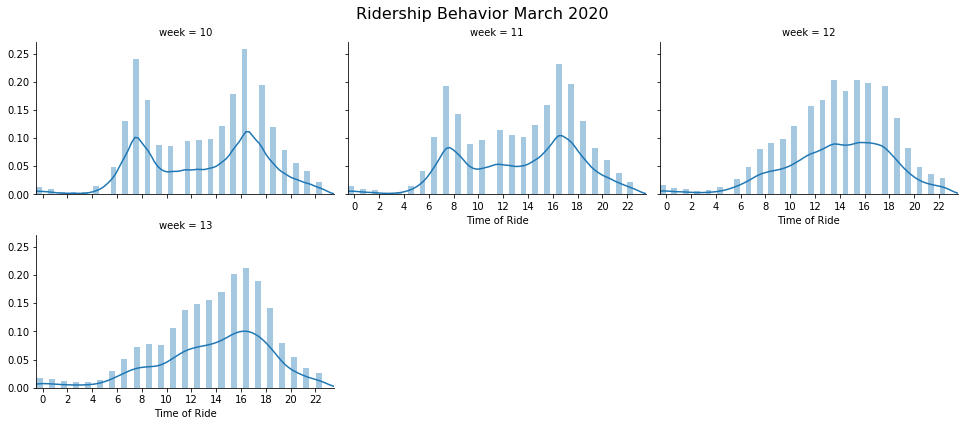

In [5]:
# Remove data from weeks 9 and 14
df_cut = df[df.week.isin([9, 14]) == False]
df_cut19 = df19[df19.week.isin([9, 14]) == False]

g = sn.FacetGrid(data=df_cut, col = 'week', col_wrap=3, aspect = 1.5)
g.map(sn.distplot, 'start_hour')
g = (g.set_axis_labels("Time of Ride").set(xlim=(0,24), xticks=(np.arange(0.5, 26.5, 2)),
                                           xticklabels=(np.arange(0, 26, 2))))
g.fig.suptitle("Ridership Behavior March 2020", size = 16)
g.fig.subplots_adjust(top=0.9)
plt.show(g)

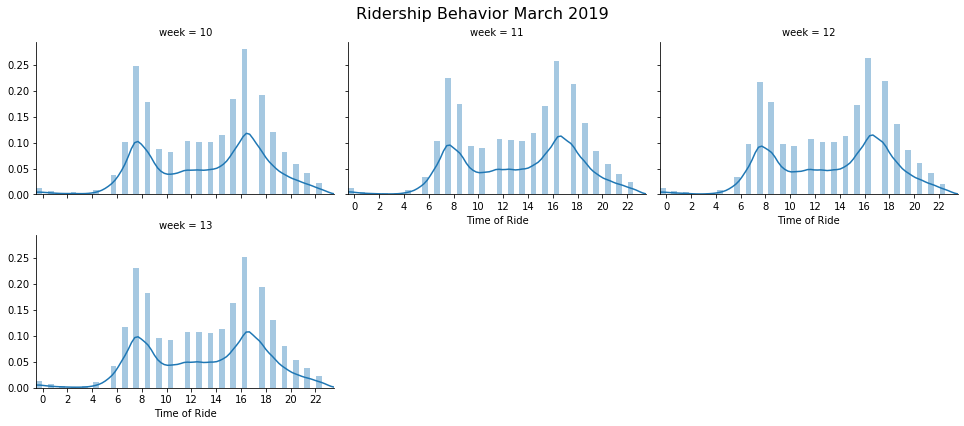

In [6]:
g = sn.FacetGrid(data=df_cut19, col = 'week', col_wrap=3, aspect = 1.5)
g.map(sn.distplot, 'start_hour')
g = (g.set_axis_labels("Time of Ride").set(xlim=(0,24), xticks=(np.arange(0.5, 26.5, 2)),
                                           xticklabels=(np.arange(0, 26, 2))))
g.fig.suptitle("Ridership Behavior March 2019", size = 16)
g.fig.subplots_adjust(top=0.9)

## Popular Routes under Quarantine

Some routes gained popularity after stay-at-home orders were in place. Surprisingly, these tended to be round trips. The following figure outlines rider behavior in in these routes, where the names listed are those of the starting and ending locations. For most of the routes shown, the number of rides taken as well as the duration of each ride actually increases from the beginning of March to the end. 



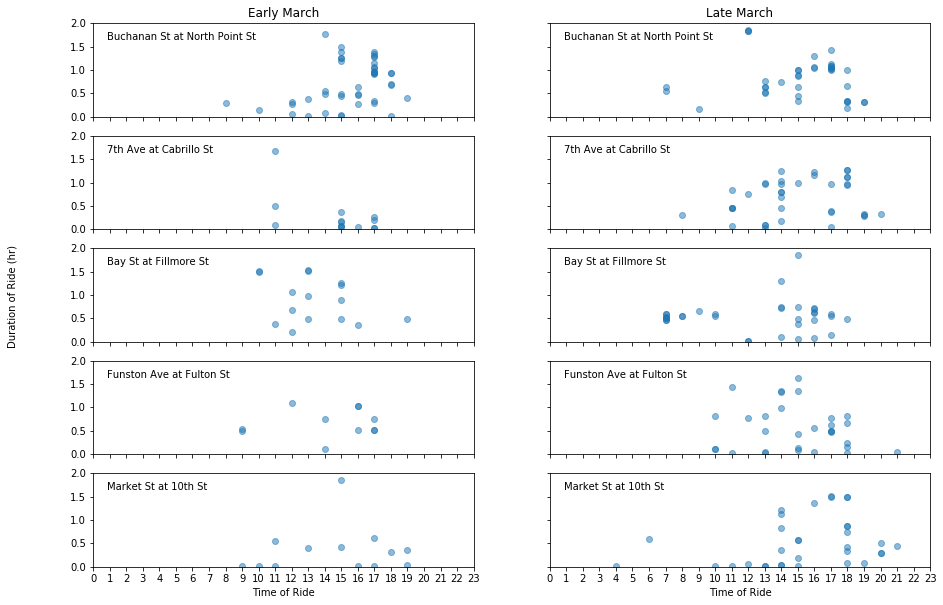

In [7]:
# Create dict to split March into 'early' and 'late' March
_map = {k:'early' for k in [10, 11]}
_map.update({k:'late' for k in [12, 13]})

# Using the DataFrame where weeks 9 and 14 are removed, use dictionary to create week location ('week_loc') column
df_cut['week_loc'] = df.loc[:, 'start_time'].dt.week
df_cut.loc[:, 'week_loc'].replace(_map, inplace = True)

# Pull popular routes
latePairs = pd.DataFrame(df_cut[df_cut.week_loc == 'late']
                         .groupby(['start_station_name', 'end_station_name']).size())
latePairs.columns = ['num_of_rides']
latePairs = latePairs.sort_values('num_of_rides', ascending=False).iloc[0:10]
latePairs

# Get list of starting locations for popular pairs
lateLocs = latePairs.index.get_level_values('start_station_name')

# Filter DataFrame for trips of interest
early_pairs_df = df_cut[(df_cut.week_loc == 'early') &
             (df_cut.start_station_name.isin(lateLocs)) &
            (df_cut.end_station_name.isin(lateLocs) & 
            (df_cut.start_station_name == df_cut.end_station_name))]

late_pairs_df = df_cut[(df_cut.week_loc == 'late') &
             (df_cut.start_station_name.isin(lateLocs)) &
            (df_cut.end_station_name.isin(lateLocs) & 
            (df_cut.start_station_name == df_cut.end_station_name))]

pairs_df = df_cut[(df_cut.start_station_name.isin(lateLocs)) &
            (df_cut.end_station_name.isin(lateLocs) & 
            (df_cut.start_station_name == df_cut.end_station_name))]

# Plot
f, ax = plt.subplots(5, 2, figsize=(15, 10), sharex=True, sharey=True)

for j in range(2):
    for i in range(5):
        tmp = early_pairs_df if j==0 else late_pairs_df
        _df = tmp[tmp.start_station_name == lateLocs[i]]
        ax[i][j].scatter(_df['start_hour'], _df['duration_hour'], alpha = 0.5, label = lateLocs[i])
        ax[i][j].legend(loc = 'upper left', markerscale=0, handletextpad=-1.5, frameon = False)

ax[0][0].set_title('Early March')
ax[0][1].set_title('Late March')
ax[4][0].set_xlabel('Time of Ride') 
ax[4][1].set_xlabel('Time of Ride')
f.text(0.05, .5, 'Duration of Ride (hr)', ha = 'center', va='center', rotation = 'vertical')
plt.xlim(0, 23)
plt.xticks(np.arange(0, 24))
plt.ylim(0, 2);